In [20]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense,Embedding,LSTM,SpatialDropout1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PARCHU\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PARCHU\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
data="C:/Users/PARCHU/Downloads/imdb_master/imdb_master.csv"


In [22]:
import chardet
with open(data,'rb')as rawdata:
    result=chardet.detect(rawdata.read(100000))
result

{'encoding': 'CP949', 'confidence': 0.99, 'language': 'Korean'}

In [23]:
movie_review=pd.read_csv(data,encoding='ISO-8859-1')

In [24]:
movie_review

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt
...,...,...,...,...,...
99995,99995,train,"Delightfully awful! Made by David Giancola, a ...",unsup,9998_0.txt
99996,99996,train,"Watching Time Chasers, it obvious that it was ...",unsup,9999_0.txt
99997,99997,train,At the beginning we can see members of Troma t...,unsup,999_0.txt
99998,99998,train,"The movie was incredible, ever since I saw it ...",unsup,99_0.txt


In [25]:
movie_review.isnull().sum()

Unnamed: 0    0
type          0
review        0
label         0
file          0
dtype: int64

In [26]:
movie_review=movie_review.drop("Unnamed: 0",axis=1)

In [27]:
movie_review

,type,review,label,file
0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt
...,...,...,...,...
99995,train,"Delightfully awful! Made by David Giancola, a ...",unsup,9998_0.txt
99996,train,"Watching Time Chasers, it obvious that it was ...",unsup,9999_0.txt
99997,train,At the beginning we can see members of Troma t...,unsup,999_0.txt
99998,train,"The movie was incredible, ever since I saw it ...",unsup,99_0.txt


In [28]:
def cleaning(df,stop_words):
    
    df['review']=df['review'].apply(lambda x:' '.join(x.lower() for x in x.split())) 

    df['review'] = df['review' ].str.replace('[^ws]', '')

    df['review'] = df['review'].str.replace('d', '')

    df['review'] = df['review'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))

    df['review'] = df['review'].apply(lambda x:  ' '.join([Word(x).lemmatize() for x in x.split()]))

    return df

stop_words = stopwords.words('english')

movie_review= cleaning(movie_review, stop_words)



C:\Users\PARCHU\AppData\Local\Temp/ipykernel_8756/3855671022.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review'] = df['review' ].str.replace('[^ws]', '')


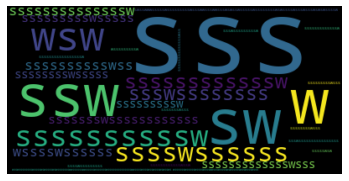

In [29]:
common_words=''
for i in movie_review.review:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [30]:
lb=LabelEncoder()
movie_review['label'] = lb.fit_transform(movie_review['label'])

In [31]:
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(movie_review['review'].values)
X = tokenizer.texts_to_sequences(movie_review['review'].values)
X = pad_sequences(X)

In [32]:
model=Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 120)            60000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 1, 120)           0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 176)               209088    
                                                                 
 dense (Dense)               (None, 3)                 531       
                                                                 
Total params: 269,619
Trainable params: 269,619
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
y=pd.get_dummies(movie_review['label'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 1)

In [36]:
model.fit(X_train, y_train, epochs = 5, batch_size=45, verbose = 'auto')
 

Epoch 1/5
1556/1556 [==============================] - 14s 9ms/step - loss: 1.0309 - accuracy: 0.5069
Epoch 2/5
1556/1556 [==============================] - 14s 9ms/step - loss: 1.0305 - accuracy: 0.5070
Epoch 3/5
1556/1556 [==============================] - 14s 9ms/step - loss: 1.0302 - accuracy: 0.5070
Epoch 4/5
1556/1556 [==============================] - 14s 9ms/step - loss: 1.0300 - accuracy: 0.5070
Epoch 5/5
1556/1556 [==============================] - 14s 9ms/step - loss: 1.0299 - accuracy: 0.5071


In [37]:
model.evaluate(X_test,y_test)

938/938 [==============================] - 3s 3ms/step - loss: 1.0451 - accuracy: 0.4982


[1.0451232194900513, 0.498199999332428]